In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf


In [10]:

stock_data = yf.download('TSLA', start='2015-01-01', end='2024-01-01')
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open    Volume
Ticker           TSLA       TSLA       TSLA       TSLA      TSLA
Date                                                            
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500
2015-01-06  14.085333  14.280000  13.614000  14.004000  93928500
2015-01-07  14.063333  14.318667  13.985333  14.223333  44526000
2015-01-08  14.041333  14.253333  14.000667  14.187333  51637500


In [11]:

data = stock_data[['Close']]


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


time_step = 60
X, y = create_dataset(scaled_data, time_step)


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [12]:
# Define the LSTM model
model = Sequential()

# Add LSTM layer (input_shape: time_step, number of features)
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

## Add a fully connected layer
model.add(Dense(units=1))  # Predicting a single value (next day's stock price)

## Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

##Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
56/56 [==============================] - 11s 102ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 0.0015 - val_loss: 0.0078
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 8/20
56/56 [==============================] - 3s 60ms/step - loss: 9.9782e-04 - val_loss: 0.0017
Epoch 9/20
56/56 [==============================] - 3s 61ms/step - loss: 9.8373e-04 - val_loss: 0.0017
Epoch 10/20
56/56 [==============================] - 3s 62ms/step - loss: 0.0011 - val_loss: 0.0015

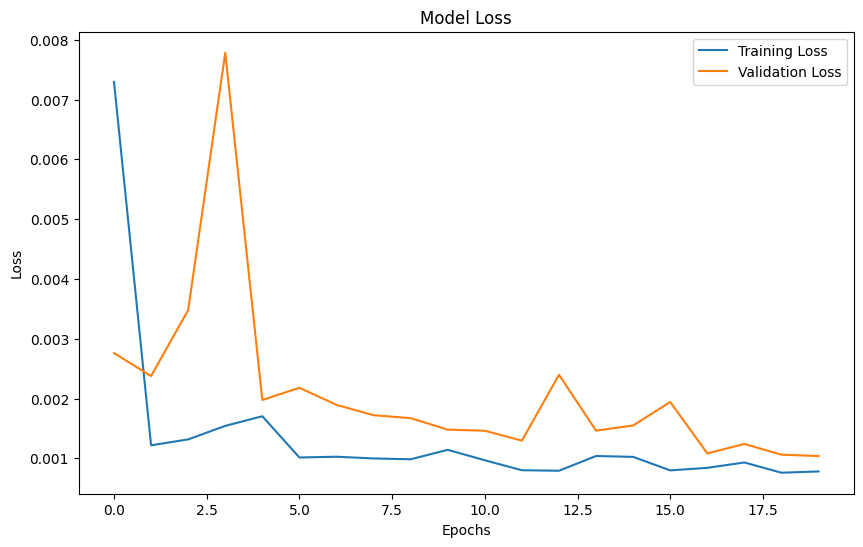

In [14]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


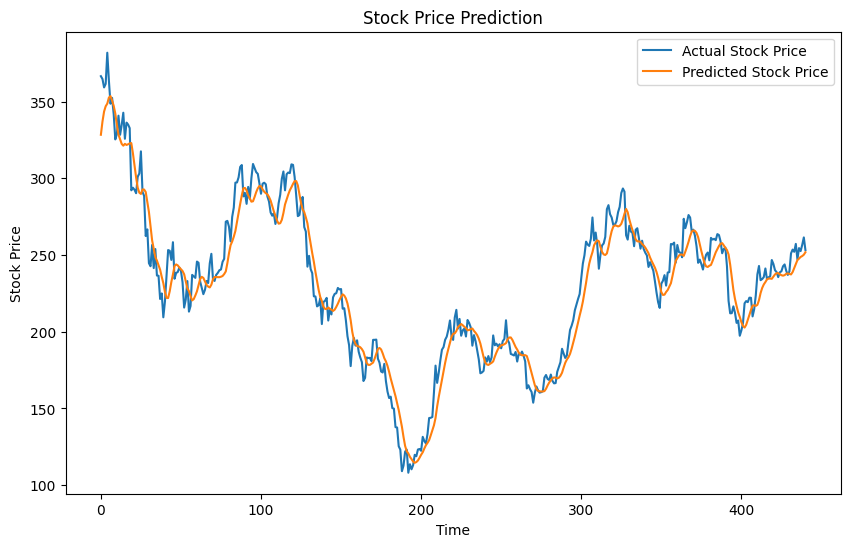

In [15]:

predicted_stock_price = model.predict(X_test)

# Inverse transform the predicted data to original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Stock Price')
plt.plot(predicted_stock_price, label='Predicted Stock Price')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()


In [16]:

last_60_days = scaled_data[-60:].reshape(1, 60, 1)

predicted_price = model.predict(last_60_days)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Stock Price for next day: {predicted_price[0][0]}")


Predicted Stock Price for next day: 251.28366088867188
